# Using RNN variant LSTM to predict Forex Exchange Rate
The purpose of the project is to create and train a Recurrent Neural Network(RNN) to perform time series prediction on Forex exchange rates. The variant of RNNs to be used is the Long Short Term Memory(LSTM). This project adapts code from a Kaggle notebook that created a LSTM to predict IBM stock price highs. For reference, this notebook can be found at the link below:
https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

## Imports

In [411]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers.legacy import SGD
import math
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as web
import datetime

Some functions from the reference notebook for visualising and evaluating the created models.<br>
Some small changes were required to make these work for this projects's requirements

In [412]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Spot Exchange Rate')
    plt.plot(predicted, color='blue',label='Predicted Spot Exchange Rate')
    plt.title('USD-EUR Exchange Rate')
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Data Import
While the project being followed used an imported csv of IBM stock prices, this project will use webscraping to import the Forex spot exchange rate for USD to Euros

In [413]:
tickers = ['DEXUSEU']
data_source = 'fred'
end_date = datetime.date.today()
df = web.DataReader(tickers, data_source,'2020-01-01', datetime.date.today())

## Data Exploration

In [414]:
df.head()

,DEXUSEU
DATE,
2020-01-01,NaN
2020-01-02,1.1166
2020-01-03,1.1173
2020-01-06,1.1187
2020-01-07,1.1138


Dataset contains 1060 which is not very large, more data may have to be added once Model Evaluation occurs

In [415]:
df.describe()

,DEXUSEU
count,1060.000000
mean,1.113045
std,0.061197
min,0.961600
25%,1.074300
50%,1.099050
75%,1.173325
max,1.229500


In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1108 entries, 2020-01-01 to 2024-03-29
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXUSEU  1060 non-null   float64
dtypes: float64(1)
memory usage: 17.3 KB


There are only 48 null value to be removed in data cleaning.

In [417]:
total_rows = df.count()
print("Total Rows: ", total_rows)
rows_with_null = df.isnull().sum()
print("Rows with null: ", rows_with_null)

Total Rows:  DEXUSEU    1060
dtype: int64
Rows with null:  DEXUSEU    48
dtype: int64


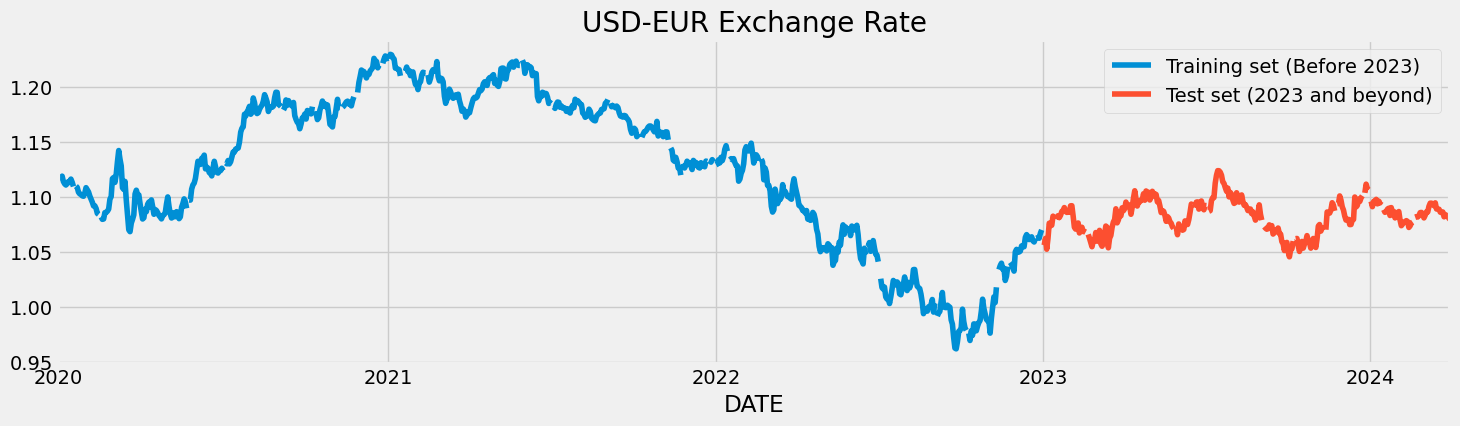

In [418]:
df["DEXUSEU"][:'2022'].plot(figsize=(16,4),legend=True)
df["DEXUSEU"]['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2023)','Test set (2023 and beyond)'])
plt.title('USD-EUR Exchange Rate')

plt.show()

## Data Preprocessing

Data cleaning is required here to remove null values

In [419]:
df = df.dropna()
df.isnull().sum()

DEXUSEU    0
dtype: int64

Now we split the training and test data. Test data will be any dates after 2023. Roughly a 70/30 split.<br>
Small modifications needed to suit switched dataset.

In [420]:
training_set = df[:'2022'].iloc[:,0:1].values
test_set = df['2023':].iloc[:,0:1].values

In [421]:
training_set.shape

(749, 1)

In [422]:
test_set.shape

(311, 1)

Next preprocessing step is to normalise the data.<br>
Small modification required to original notebook to get MinMaxScaler to work.

In [423]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

For training an LSTM we create sequences of time variant data using 60 previous times steps and their values. These sets of time periods are then used to train the model. In the code below we set the range to start at 60 for the first set of values obtained by i-60.

In [424]:
X_train = []
y_train = []
for i in range(60,749):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

First set of training data.

In [425]:
X_train[0]

array([0.57857409, 0.58118701, 0.58641284, 0.56812243, 0.56028369,
       0.55617768, 0.56103024, 0.56812243, 0.56513624, 0.57633445,
       0.56550952, 0.55132512, 0.55244494, 0.54833893, 0.53191489,
       0.52631579, 0.52370287, 0.51959686, 0.51810377, 0.52855543,
       0.54721911, 0.53975364, 0.53266144, 0.51885032, 0.50877193,
       0.497947  , 0.48525569, 0.48562897, 0.4766704 , 0.45987309,
       0.45651362, 0.44755506, 0.43971631, 0.44083613, 0.462486  ,
       0.46323255, 0.46733856, 0.47443076, 0.50802538, 0.51698395,
       0.57782755, 0.58193356, 0.56513624, 0.59201194, 0.63568496,
       0.67338559, 0.64427025, 0.62112729, 0.54684584, 0.54124673,
       0.56849571, 0.50578574, 0.45427398, 0.40425532, 0.39790967,
       0.42702501, 0.43971631, 0.45502053, 0.52594252, 0.53863382])

Last set of training data.

In [426]:
X_train[-1]

array([0.07204181, 0.13475177, 0.0933184 , 0.07092199, 0.06308324,
       0.05263158, 0.02836879, 0.06121687, 0.04591265, 0.08473311,
       0.08435984, 0.06121687, 0.07726764, 0.08921239, 0.09630459,
       0.12803285, 0.16871967, 0.13773796, 0.11870101, 0.1004106 ,
       0.09518477, 0.09667786, 0.05337813, 0.10414334, 0.14221725,
       0.17655842, 0.15714819, 0.20903322, 0.26913027, 0.28219485,
       0.29078014, 0.27062337, 0.27360956, 0.23217619, 0.24636058,
       0.27920866, 0.29339306, 0.28742068, 0.27622247, 0.26390444,
       0.32922732, 0.33781262, 0.32773423, 0.32885405, 0.33184024,
       0.3493841 , 0.34863755, 0.34677118, 0.37849944, 0.38783128,
       0.38148563, 0.37103397, 0.3762598 , 0.38036581, 0.36692796,
       0.36282195, 0.37513998, 0.38745801, 0.37551325, 0.39268384])

In [427]:
X_train.shape

(689, 60)

Reshaping to add a third dimension to fit the input layer and represent number of features at each time step.

In [428]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [429]:
X_train.shape

(689, 60, 1)

In [430]:
len(X_train)

689

## Model Creation

### Model 1

For the first model we will use the LSTM from the notebook to get an idea of its current performance on this task.<br>
Evaluating this model:<br>
1. Input Layer
- The input layer also serves as a processing layer
- This is a LSTM layer with 50 neurons (units) designed to process sequential data
- return_sequences is True which means this layer will output hidden states for each timestep which lower layers can access
2. Hidden Layers
- The model has four dropout layers to randomly drop data to prevent overfitting.
- The model has 3 further LSTM layers with 50 neurons with the last having return_sequence set to false by default
3. Output Layer
- The model has an output layer which will output a single continous value
4. Configuration
- The model uses the rmsprop optimiser
- The loss function is mean_squared_error as this is a Regression task


In [431]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 9s 63ms/step - loss: 0.0543
Epoch 2/50
22/22 [==============================] - 1s 65ms/step - loss: 0.0241
Epoch 3/50
22/22 [==============================] - 1s 65ms/step - loss: 0.0205
Epoch 4/50
22/22 [==============================] - 1s 64ms/step - loss: 0.0164
Epoch 5/50
22/22 [==============================] - 2s 71ms/step - loss: 0.0158
Epoch 6/50
22/22 [==============================] - 1s 65ms/step - loss: 0.0157
Epoch 7/50
22/22 [==============================] - 2s 98ms/step - loss: 0.0140
Epoch 8/50
22/22 [==============================] - 2s 74ms/step - loss: 0.0132
Epoch 9/50
22/22 [==============================] - 1s 67ms/step - loss: 0.0144
Epoch 10/50
22/22 [==============================] - 2s 75ms/step - loss: 0.0105
Epoch 11/50
22/22 [==============================] - 2s 77ms/step - loss: 0.0112
Epoch 12/50
22/22 [==============================] - 2s 90ms/step - loss: 0.0116
Epoch 13/50
22/22 [==================

Model 1 architecture.

In [432]:
regressor.summary()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_491 (LSTM)             (None, 60, 50)            10400     
                                                                 
 dropout_510 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_492 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_511 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_493 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_512 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_494 (LSTM)             (None, 50)             

Prepare a combined dataset for graphing and model evaluation

In [433]:
dataset_total = pd.concat((df["DEXUSEU"][:'2022'],df["DEXUSEU"]['2023':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
dataset_total

DATE
2020-01-02    1.1166
2020-01-03    1.1173
2020-01-06    1.1187
2020-01-07    1.1138
2020-01-08    1.1117
               ...  
2024-03-25    1.0837
2024-03-26    1.0829
2024-03-27    1.0821
2024-03-28    1.0801
2024-03-29    1.0791
Name: DEXUSEU, Length: 1060, dtype: float64

In [434]:
len(inputs)

371

Preparing the test set data

In [435]:
X_test = []
for i in range(60,371):
    X_test.append(inputs[i-60:i,0])


In [436]:
len(X_test)

311

In [437]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 [==============================] - 2s 30ms/step


#### Model 1 Evaluation

Model 1 performed very quite well with this task. We have a mean squared error of only 0.012 which given our dataset is normalised between 0 and 1 is a fairly good result. We can see that while the predicted values do not conform to small variations in the dataset, the line created does roughly follow the actual values quite well, especially when we consider the limited dataset used so far for Model 1's training.

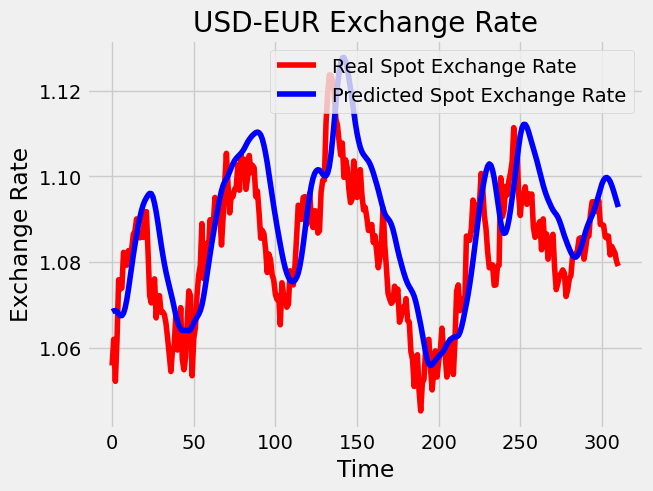

In [438]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [439]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.012049187868164363.


### Model 2
We saw that Model 1 was not conforming to small variations in the actual values so for Model 2, we add neurons and a fifth LSTM layer to enable the model to learn deeper complexities in the patterns in an to attempt to see if we can get a better fit. The model is switched to the Adam optimiser because although more computationally expensive, it can speed up convergence which may improve out learning rate. <br>
Note: A test run with an increased dropout to 0.3 did not improve results so overfitting to the dataset does not seem to be the issue preventing better results, perhaps underfitting is more likely given the limited dataset.

In [440]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 10s 102ms/step - loss: 0.0762
Epoch 2/50
22/22 [==============================] - 2s 99ms/step - loss: 0.0139
Epoch 3/50
22/22 [==============================] - 2s 97ms/step - loss: 0.0087
Epoch 4/50
22/22 [==============================] - 2s 91ms/step - loss: 0.0086
Epoch 5/50
22/22 [==============================] - 2s 98ms/step - loss: 0.0076
Epoch 6/50
22/22 [==============================] - 3s 126ms/step - loss: 0.0078
Epoch 7/50
22/22 [==============================] - 3s 119ms/step - loss: 0.0067
Epoch 8/50
22/22 [==============================] - 3s 116ms/step - loss: 0.0070
Epoch 9/50
22/22 [==============================] - 3s 128ms/step - loss: 0.0074
Epoch 10/50
22/22 [==============================] - 3s 134ms/step - loss: 0.0066
Epoch 11/50
22/22 [==============================] - 3s 118ms/step - loss: 0.0061
Epoch 12/50
22/22 [==============================] - 3s 122ms/step - loss: 0.0068
Epoch 13/50
22/22 [=========

#### Model 2 Evaluation

This Model performs almost identically to Model 1 with a MSE of .0099 meaning adding complexity had practically no benefit in this case. This is probably because the dataset being used is small so there is not enough data for a more complex model to increase its performance.<br>
Another interesting observation is that the model predictions from both Model 1 and Model 2 seem to be offset from the true values. This may indicate that the model is learning to simply predict the previous value in the time series and is actually not learning the pattern at all. For the next attempt I will increase the dataset size and see if this improves this issue.

10/10 [==============================] - 2s 37ms/step


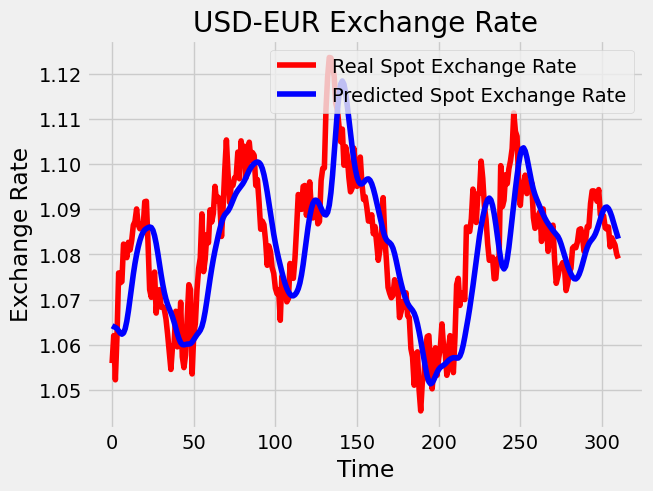

In [441]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plot_predictions(test_set,predicted_stock_price)

In [442]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 0.0099177639162616.


### Model 3
For Model 3 no changes will be made to the dataset but instead the dataset will be extended to include dates from 2018 onwards to see if giving the model access too additional instances of the exchange rate fluctuations will increase model performance.

#### Increase available data in dataset

Total Rows:  DEXUSEU    1558
dtype: int64
Rows with null:  DEXUSEU    72
dtype: int64


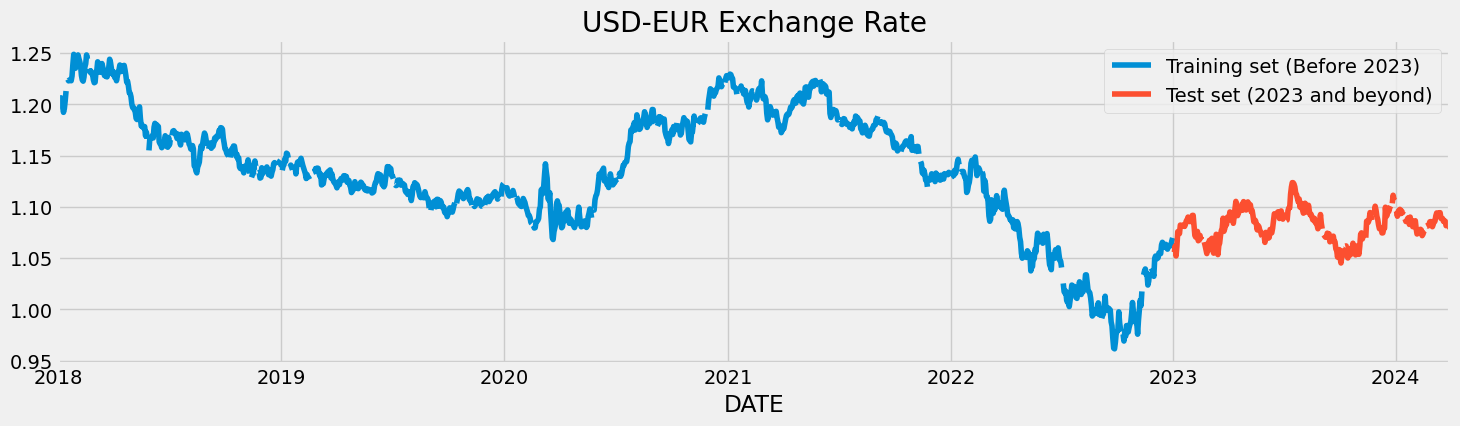

In [443]:
tickers = ['DEXUSEU']
end_date = datetime.date.today()
df_extended = web.DataReader(tickers, 'fred','2018-01-01', datetime.date.today())
total_rows = df_extended.count()
print("Total Rows: ", total_rows)
rows_with_null = df_extended.isnull().sum()
print("Rows with null: ", rows_with_null)
# We have chosen 'High' attribute for prices. Let's see what it looks like
df_extended["DEXUSEU"][:'2022'].plot(figsize=(16,4),legend=True)
df_extended["DEXUSEU"]['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2023)','Test set (2023 and beyond)'])
plt.title('USD-EUR Exchange Rate')

plt.show()

Create new training and test data

In [444]:
df_extended = df_extended.dropna()
df_extended.isnull().sum()
training_set_e = df_extended[:'2022'].iloc[:,0:1].values
test_set_e = df_extended['2023':].iloc[:,0:1].values
sc = MinMaxScaler()
training_set_scaled_e = sc.fit_transform(training_set_e)
X_train_e = []
y_train_e = []
for i in range(60,749):
    X_train_e.append(training_set_scaled_e[i-60:i,0])
    y_train_e.append(training_set_scaled_e[i,0])
X_train_e, y_train_e = np.array(X_train_e), np.array(y_train_e)
X_train_e = np.reshape(X_train_e, (X_train_e.shape[0],X_train_e.shape[1],1))

In [445]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_e.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train_e,y_train_e,epochs=50,batch_size=32)

Epoch 1/50
22/22 [==============================] - 10s 91ms/step - loss: 0.0544
Epoch 2/50
22/22 [==============================] - 2s 95ms/step - loss: 0.0096
Epoch 3/50
22/22 [==============================] - 2s 90ms/step - loss: 0.0074
Epoch 4/50
22/22 [==============================] - 2s 94ms/step - loss: 0.0054
Epoch 5/50
22/22 [==============================] - 2s 91ms/step - loss: 0.0051
Epoch 6/50
22/22 [==============================] - 2s 110ms/step - loss: 0.0061
Epoch 7/50
22/22 [==============================] - 2s 112ms/step - loss: 0.0063
Epoch 8/50
22/22 [==============================] - 3s 119ms/step - loss: 0.0047
Epoch 9/50
22/22 [==============================] - 2s 111ms/step - loss: 0.0060
Epoch 10/50
22/22 [==============================] - 2s 112ms/step - loss: 0.0050
Epoch 11/50
22/22 [==============================] - 3s 115ms/step - loss: 0.0044
Epoch 12/50
22/22 [==============================] - 2s 109ms/step - loss: 0.0041
Epoch 13/50
22/22 [==========

Now prepare extended dataset.

In [446]:
dataset_total_e = pd.concat((df_extended["DEXUSEU"][:'2022'],df_extended["DEXUSEU"]['2023':]),axis=0)
inputs_e = dataset_total_e[len(dataset_total_e)-len(test_set_e) - 60:].values
inputs_e = inputs_e.reshape(-1,1)
inputs_e  = sc.transform(inputs_e)
dataset_total_e

DATE
2018-01-02    1.2050
2018-01-03    1.2030
2018-01-04    1.2064
2018-01-05    1.2039
2018-01-08    1.1973
               ...  
2024-03-25    1.0837
2024-03-26    1.0829
2024-03-27    1.0821
2024-03-28    1.0801
2024-03-29    1.0791
Name: DEXUSEU, Length: 1558, dtype: float64

In [447]:
len(inputs_e)

371

In [448]:
X_test_e = []
for i in range(60,371):
    X_test_e.append(inputs_e[i-60:i,0])


#### Model 3 Evaluation
Model 3 shows no improvement when given more instances of the same data. This is not really surprising as it seems clear now that the model is learning to simply predict the previous value as once again the prediction is just the real spot prices shifted forward. The next steps will be to try to add more indicators from which the model can learn. Upon reflection predicting a Forex price in a vacuum is probably impossible given that its pattern is controlled by external factors more than having a particular pattern a model can learn.

10/10 [==============================] - 2s 37ms/step


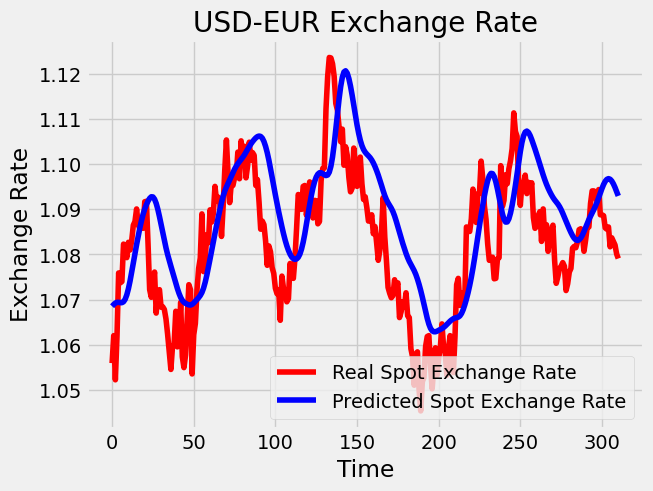

In [449]:
X_test_e = np.array(X_test_e)
X_test_e = np.reshape(X_test_e, (X_test_e.shape[0],X_test_e.shape[1],1))
predicted_stock_price = regressor.predict(X_test_e)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
plot_predictions(test_set_e,predicted_stock_price)

In [450]:
return_rmse(test_set_e,predicted_stock_price)

The root mean squared error is 0.012176034792733102.


### Model 4

#### Additional Features
For the next model, we will attempt to include some external indicators that could indicate market sentiment and thus give the model more data on how the exchange rate may change. Credit to Paul Bacher's guide found here for these indicators: https://www.kaggle.com/code/paulbacher/forex-trend-predictions-classic-ml-approach

In [451]:
import pandas_ta as ta
import yfinance as yf

dfn = yf.download(tickers='USDEUR=X',
                 period='2000d',
                 interval='1d')
dfn= dfn.drop(['Volume', 'Adj Close'], axis=1)
dfn.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2016-08-08,0.90190,0.903040,0.900414,0.90175
2016-08-09,0.90197,0.903179,0.899119,0.90223
2016-08-10,0.89943,0.899430,0.892857,0.89962
2016-08-11,0.89397,0.897827,0.893580,0.89394
2016-08-12,0.89775,0.898260,0.891266,0.89774


In [452]:
dfn.tail()

,Open,High,Low,Close
Date,,,,
2024-04-02,0.93134,0.93237,0.92775,0.93134
2024-04-03,0.92863,0.92896,0.92320,0.92863
2024-04-04,0.92265,0.92293,0.91947,0.92265
2024-04-05,0.92276,0.92664,0.92179,0.92276
2024-04-06,0.92240,0.92240,0.92240,0.92240


In [453]:
dfn.describe()

,Open,High,Low,Close
count,1998.000000,1998.000000,1998.000000,1998.000000
mean,0.891834,0.894599,0.889128,0.891815
std,0.045440,0.045972,0.044901,0.045445
min,0.799190,0.803180,0.796300,0.799360
25%,0.852977,0.855511,0.850765,0.852985
50%,0.891900,0.894115,0.889300,0.891991
75%,0.921963,0.924773,0.919073,0.921902
max,1.042080,1.048200,1.034120,1.042080


Check for any null values

In [454]:
dfn.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

Here we use the pandas_ta library to compute some additional Technical indicators.
Added Indicator Descriptions
1. ATR (Average True Range): Measures market volatility by calculating the average range between the high and low prices over a specified period (in this case, 20 days).
2. RSI (Relative Strength Index): Indicates the magnitude of recent price changes to evaluate whether a stock is overbought or oversold, typically over a 14-day period by default.
3. Average: Calculates the average price between the high and low prices for each day, providing a reference point for market activity over a one-day period.
4. MA40 (40-day Moving Average): Smooths out price data by calculating the average closing price over the past 40 days, providing insight into the overall trend direction.
5. MA80 (80-day Moving Average): Similar to MA40 but calculates the average closing price over the past 80 days, offering a longer-term perspective on the trend direction.
6. MA160 (160-day Moving Average): Computes the average closing price over the past 160 days, providing an even longer-term view of the trend direction and smoothing out short-term fluctuations.

In [455]:
dfn['ATR'] = dfn.ta.atr(length=20)
dfn['RSI'] = dfn.ta.rsi()
dfn['Average'] = dfn.ta.midprice(length=1)
dfn['MA40'] = dfn.ta.sma(length=40)
dfn['MA80'] = dfn.ta.sma(length=80)
dfn['MA160'] = dfn.ta.sma(length=160)

Drop any rows with Nan values

In [456]:
dfn = dfn.dropna()
dfn.isnull().sum()

Open       0
High       0
Low        0
Close      0
ATR        0
RSI        0
Average    0
MA40       0
MA80       0
MA160      0
dtype: int64

Now we prepare the new extended dataset for Model Training

In [457]:
dfn.head()

,Open,High,Low,Close,ATR,RSI,Average,MA40,MA80,MA160
Date,,,,,,,,,,
2017-03-17,0.92846,0.93198,0.927386,0.92810,0.007521,38.137056,0.929683,0.938900,0.942946,0.922994
2017-03-20,0.93090,0.93090,0.927902,0.93084,0.007295,41.138971,0.929401,0.938837,0.942803,0.923176
2017-03-21,0.93138,0.93138,0.924300,0.93130,0.007284,41.650843,0.927840,0.938887,0.942676,0.923358
2017-03-22,0.92496,0.92794,0.924150,0.92486,0.007277,36.822606,0.926045,0.938706,0.942498,0.923515
2017-03-23,0.92681,0.92846,0.925500,0.92677,0.007093,39.078216,0.926980,0.938624,0.942281,0.923720


Move close to end of dataset

In [458]:
close_column = dfn.pop('Close')
dfn['Close'] = close_column

In [459]:
dfn.head()

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160,Close
Date,,,,,,,,,,
2017-03-17,0.92846,0.93198,0.927386,0.007521,38.137056,0.929683,0.938900,0.942946,0.922994,0.92810
2017-03-20,0.93090,0.93090,0.927902,0.007295,41.138971,0.929401,0.938837,0.942803,0.923176,0.93084
2017-03-21,0.93138,0.93138,0.924300,0.007284,41.650843,0.927840,0.938887,0.942676,0.923358,0.93130
2017-03-22,0.92496,0.92794,0.924150,0.007277,36.822606,0.926045,0.938706,0.942498,0.923515,0.92486
2017-03-23,0.92681,0.92846,0.925500,0.007093,39.078216,0.926980,0.938624,0.942281,0.923720,0.92677


#### Visualise new Data

We can see that these features have a clear covariance which is to be expected given that the columns such as MA60 are just moving averages of the exchange rate figures. RSI is the only column which is not tightly coupled but instead jumps around which again is understandable as it is a sentiment metric measuring strength of stock market buying. The covariance of all the related columns may cause the model to overfit to a pattern which we may have to consider in model evaluation.

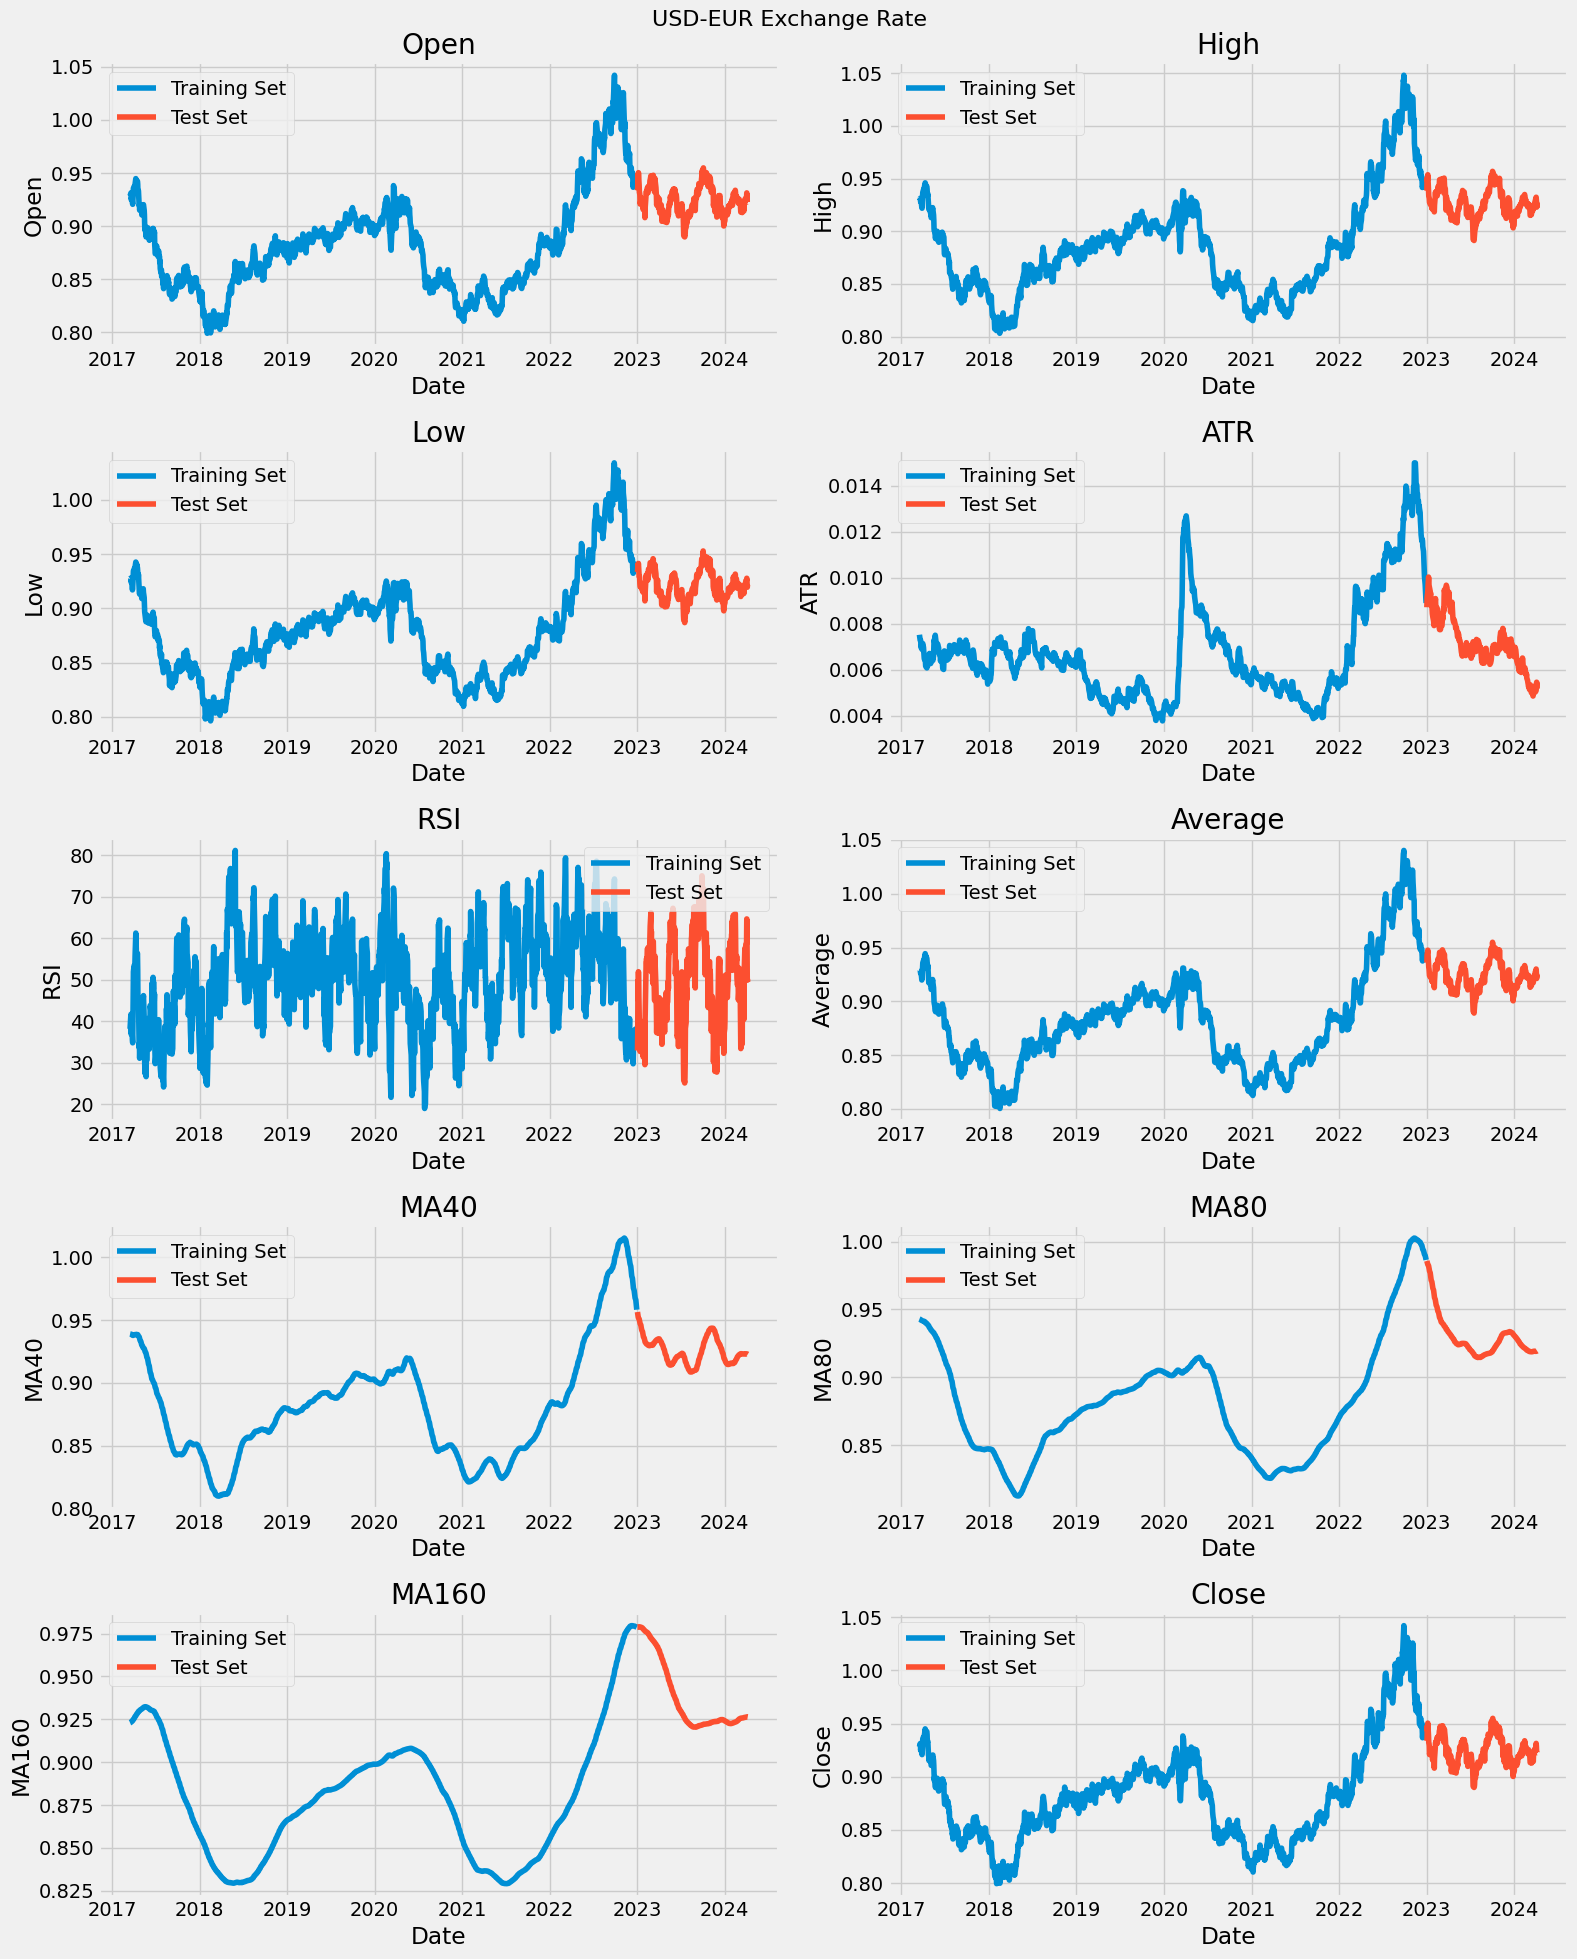

In [468]:
# Plotting each column separately in subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
fig.suptitle('USD-EUR Exchange Rate', fontsize=16)

for i, column in enumerate(dfn.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(dfn[column][:'2022'], label='Training Set')
    axs[row, col].plot(dfn[column]['2023':], label='Test Set')
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel(column)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [460]:
dfn['2023':].iloc[:,0:9]

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160
Date,,,,,,,,,
2023-01-02,0.93373,0.93868,0.93350,0.008717,32.925536,0.936090,0.956417,0.985754,0.978679
2023-01-03,0.93653,0.95043,0.93610,0.009116,36.790537,0.943265,0.954877,0.985120,0.978682
2023-01-04,0.94815,0.94823,0.94060,0.009245,49.735193,0.944415,0.953781,0.984449,0.978786
2023-01-05,0.94283,0.95097,0.94050,0.009306,45.173948,0.945735,0.952401,0.983715,0.978831
2023-01-06,0.95037,0.95372,0.94142,0.009456,51.906143,0.947570,0.951631,0.983080,0.978947
...,...,...,...,...,...,...,...,...,...
2024-04-02,0.93134,0.93237,0.92775,0.005111,64.627505,0.930060,0.923062,0.919215,0.926433
2024-04-03,0.92863,0.92896,0.92320,0.005263,59.413298,0.926080,0.923037,0.919247,0.926475
2024-04-04,0.92265,0.92293,0.91947,0.005457,49.854647,0.921200,0.922903,0.919298,0.926489


In [461]:
dfn['2023':].iloc[:,0:10]

,Open,High,Low,ATR,RSI,Average,MA40,MA80,MA160,Close
Date,,,,,,,,,,
2023-01-02,0.93373,0.93868,0.93350,0.008717,32.925536,0.936090,0.956417,0.985754,0.978679,0.93373
2023-01-03,0.93653,0.95043,0.93610,0.009116,36.790537,0.943265,0.954877,0.985120,0.978682,0.93653
2023-01-04,0.94815,0.94823,0.94060,0.009245,49.735193,0.944415,0.953781,0.984449,0.978786,0.94815
2023-01-05,0.94283,0.95097,0.94050,0.009306,45.173948,0.945735,0.952401,0.983715,0.978831,0.94283
2023-01-06,0.95037,0.95372,0.94142,0.009456,51.906143,0.947570,0.951631,0.983080,0.978947,0.95037
...,...,...,...,...,...,...,...,...,...,...
2024-04-02,0.93134,0.93237,0.92775,0.005111,64.627505,0.930060,0.923062,0.919215,0.926433,0.93134
2024-04-03,0.92863,0.92896,0.92320,0.005263,59.413298,0.926080,0.923037,0.919247,0.926475,0.92863
2024-04-04,0.92265,0.92293,0.91947,0.005457,49.854647,0.921200,0.922903,0.919298,0.926489,0.92265


In [469]:
training_set_n = dfn[:'2022'].iloc[:,0:10].values
test_set_en= dfn['2023':].iloc[:,0:10].values
sc = MinMaxScaler()
training_set_scaled_n = sc.fit_transform(training_set_n)

In [470]:
test_set_en[0,9]

0.9337300062179565

In [471]:
len(training_set_scaled_n)

1508

In [472]:
X_train_n = []
y_train_n = []
for i in range(60,1508):
    X_train_n.append(training_set_scaled_n[i-60:i,0:8])
    y_train_n.append(training_set_scaled_n[i,9])
X_train_n, y_train_n = np.array(X_train_n), np.array(y_train_n)
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0],X_train_n.shape[1],8))

#### Model Creation

In [480]:
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_n.shape[1],8)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train_n,y_train_n,epochs=50,batch_size=32)

Epoch 1/50
46/46 [==============================] - 15s 94ms/step - loss: 0.0118
Epoch 2/50
46/46 [==============================] - 4s 89ms/step - loss: 0.0037
Epoch 3/50
46/46 [==============================] - 5s 104ms/step - loss: 0.0035
Epoch 4/50
46/46 [==============================] - 5s 115ms/step - loss: 0.0031
Epoch 5/50
46/46 [==============================] - 5s 109ms/step - loss: 0.0030
Epoch 6/50
46/46 [==============================] - 5s 114ms/step - loss: 0.0031
Epoch 7/50
46/46 [==============================] - 5s 113ms/step - loss: 0.0025
Epoch 8/50
46/46 [==============================] - 5s 117ms/step - loss: 0.0027
Epoch 9/50
46/46 [==============================] - 5s 111ms/step - loss: 0.0027
Epoch 10/50
46/46 [==============================] - 5s 109ms/step - loss: 0.0025
Epoch 11/50
46/46 [==============================] - 5s 107ms/step - loss: 0.0024
Epoch 12/50
46/46 [==============================] - 5s 110ms/step - loss: 0.0023
Epoch 13/50
46/46 [=======

Prepare test data and evaluate model against test data.

In [481]:
# Prepare test data
dataset_total_n = pd.concat((dfn[:'2022'], dfn['2023':]), axis=0)
inputs_n = dataset_total_n[len(dataset_total_n)-len(test_set_en) - 60:].values
inputs_n = inputs_n.reshape(-1, 10)
inputs_features_n = inputs_n[:, :9]
inputs_target_n = inputs_n[:, 9:]
inputs_features_n = sc.fit_transform(inputs_features_n)
inputs_target_n = sc.fit_transform(inputs_target_n.reshape(-1, 1))
inputs_n = np.concatenate((inputs_features_n, inputs_target_n), axis=1)

In [482]:
len(inputs_n)

391

In [483]:
X_test_n = []
for i in range(60, 391):
    X_test_n.append(inputs_n[i-60:i, 0:8])
X_test_n = np.array(X_test_n)
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 8))

predicted_stock_price = regressor.predict(X_test_n)

# Inverse transform the predictions to get the unnormalized values
predicted_stock_price_unscaled = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

11/11 [==============================] - 2s 36ms/step


#### Model Evaluation

We can see that the additional data and indicators have led to a large increase in Model performance with the predicted data conforming much better to the actual values. The predicted values do not seem to be just the previous value shifted forward anymore and there is additional conformity to smaller variations. The visual improvement is also seen in the MSE which has reduced considerable to .0050

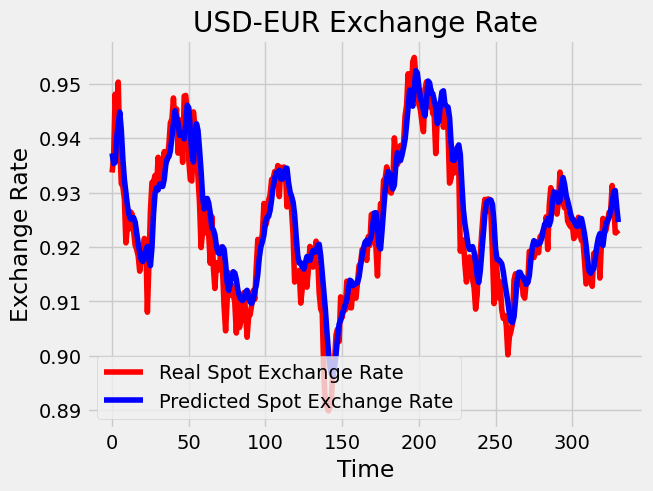

In [484]:
plot_predictions(test_set_en[:, 9],predicted_stock_price_unscaled)

In [485]:
return_rmse(test_set_en[:, 9],predicted_stock_price_unscaled)

The root mean squared error is 0.005010403265624583.


### Model 5
For this model a Gated Recurrent Unit (GRU) network will be used instead.While LSTMs have separate input, forget, and output gates, GRUs combine these gates into a single update gate and a reset gate, resulting in a simpler architecture requiring fewer parameters and computations compared to LSTMs.

In [486]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_n.shape[1],8), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train_n,y_train_n,epochs=50,batch_size=150)

Epoch 1/50


C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 7s 98ms/step - loss: 0.0712
Epoch 2/50
10/10 [==============================] - 1s 107ms/step - loss: 0.0264
Epoch 3/50
10/10 [==============================] - 1s 97ms/step - loss: 0.0121
Epoch 4/50
10/10 [==============================] - 1s 109ms/step - loss: 0.0070
Epoch 5/50
10/10 [==============================] - 1s 101ms/step - loss: 0.0055
Epoch 6/50
10/10 [==============================] - 1s 99ms/step - loss: 0.0048
Epoch 7/50
10/10 [==============================] - 1s 125ms/step - loss: 0.0044
Epoch 8/50
10/10 [==============================] - 1s 103ms/step - loss: 0.0040
Epoch 9/50
10/10 [==============================] - 1s 128ms/step - loss: 0.0040
Epoch 10/50
10/10 [==============================] - 1s 107ms/step - loss: 0.0041
Epoch 11/50
10/10 [==============================] - 2s 168ms/step - loss: 0.0040
Epoch 12/50
10/10 [==============================] - 1s 128ms/step - loss: 0.0036
Epoch 13/50
10/10 [====================

In [487]:
regressorGRU.summary()

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 60, 50)            9000      
                                                                 
 dropout_534 (Dropout)       (None, 60, 50)            0         
                                                                 
 gru_21 (GRU)                (None, 60, 50)            15300     
                                                                 
 dropout_535 (Dropout)       (None, 60, 50)            0         
                                                                 
 gru_22 (GRU)                (None, 60, 50)            15300     
                                                                 
 dropout_536 (Dropout)       (None, 60, 50)            0         
                                                                 
 gru_23 (GRU)                (None, 50)             

##### Model 5 Evaluation
The model while simpler and faster to train performs much worse than the more complex LSTM network with a MSE of .75. This shows that the additional complexity in the LSTM is paying off in terms of performance.

11/11 [==============================] - 0s 21ms/step


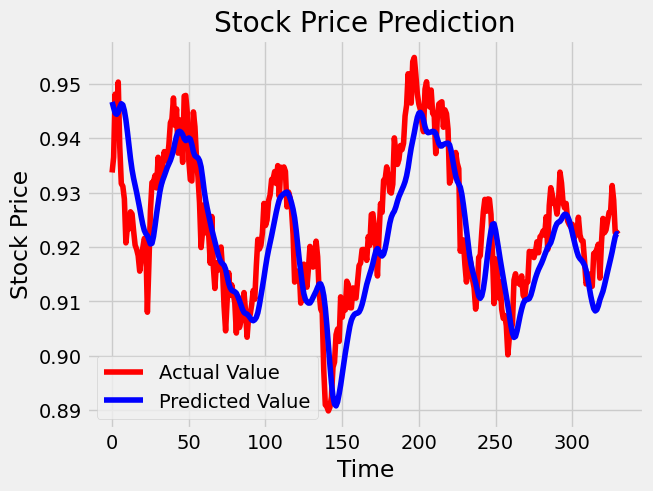

In [495]:
# Prepare test data
dataset_total_n = pd.concat((dfn[:'2022'], dfn['2023':]), axis=0)
inputs_n = dataset_total_n[len(dataset_total_n)-len(test_set_en) - 60:].values
inputs_n = inputs_n.reshape(-1, 10)
inputs_features_n = inputs_n[:, :9]
inputs_target_n = inputs_n[:, 9:]
inputs_features_n = sc.fit_transform(inputs_features_n)
inputs_target_n = sc.fit_transform(inputs_target_n.reshape(-1, 1))
inputs_n = np.concatenate((inputs_features_n, inputs_target_n), axis=1)

# Prepare the test data
X_test_n = []
for i in range(60, 391):
    X_test_n.append(inputs_n[i-60:i, 0:8])
X_test_n = np.array(X_test_n)
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 8))

# Get the normalized predictions
predicted_stock_price = regressorGRU.predict(X_test_n)

# Inverse transform the predictions to get the unnormalized values
predicted_stock_price_unscaled = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

# Plot predictions
plt.plot(test_set_en[:, 9], color='red', label='Actual Value')
plt.plot(predicted_stock_price_unscaled, color='blue', label='Predicted Value')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [496]:
# Evaluating GRU
return_rmse(test_set_en[:, 9],predicted_stock_price_unscaled)

The root mean squared error is 0.007576482018189093.
